In [17]:
! pip3 install pandas pycoingecko matplotlib scipy seaborn latextable texttable tabulate
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
import datetime as dt
import time
import tabulate
import statistics as stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
from latextable import draw_latex
from tqdm import tqdm
from pycoingecko import CoinGeckoAPI
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.formula.api import ols
from statsmodels.formula.api import wls
from statsmodels.iolib.summary2 import summary_col
from statsmodels.tsa.filters.hp_filter import hpfilter
from pandas.plotting import lag_plot

Defaulting to user installation because normal site-packages is not writeable


In [18]:
tweets_df = pd.read_csv('../data/crypto/tweets.csv')
tweets_df = tweets_df.astype({'timestamp': 'datetime64[ns]'})

In [19]:
class TweetStats:
    def __init__(self,twt_dt,df,coin,currency,creator):
        self.id = twt_dt
        self.df = df
        self.coin = coin
        self.currency = currency
        self.creator = creator
    
def get_all_tweet_dfs(twt_df,directory='../data/crypto/prices/'):
    tweet_dfs = []
    for _,row in twt_df.iterrows():
        coin = row['coin']
        currency = row['currency']
        creator = row['creator']
        timestamp = row['timestamp']
        filepath = directory + (creator.lower() + " " + coin + " vs " + currency + " " + str(timestamp) + " " + ".csv").replace(" ", "_")
        df = pd.read_csv(filepath)
        df = df.astype({'date': 'datetime64[ns]'})
        df = gen_extra_cols(df,timestamp)
        tweet_stats = TweetStats(timestamp,df,coin,currency,creator)
        tweet_dfs.append(tweet_stats)
    return tweet_dfs

In [20]:
def is_after_tweet(date,tweet_dt):
    if date < tweet_dt:
        return 0
    elif date > tweet_dt: 
        return 1
    else:
        pass
def days_since(date,tweet_dt):
    diff = date - tweet_dt
    return  diff.days + (diff.seconds / (3600 * 24))
def min_max(price,min_price,max_price):
    return (price - min_price)/(max_price-min_price)
def kernel(R,c,h):
    indicator = (np.abs(R-c) <= h).astype(float)
    return indicator * (1 - np.abs(R-c)/h)
def gaussian_kernel(R,h,c=0):
    fraction = (1/(h*np.sqrt(2*np.pi)))
    exp = np.exp(-0.5*(((R-c)/h))**2)
    return fraction * exp

In [21]:
def gen_extra_cols(original_df,twt_dt,c=0,h=1):
    expanded_df = original_df.copy()
    expanded_df['before_after'] = expanded_df['date'].map(lambda x: is_after_tweet(x,twt_dt))
    expanded_df['days_since_tweet'] = expanded_df['date'].map(lambda x: days_since(x,twt_dt))
    expanded_df['min_max_prices'] = min_max(expanded_df['prices'],min(expanded_df['prices']),max(expanded_df['prices']))
    #expanded_df['kernel_weighting'] = expanded_df['days_since_tweet'].map(lambda x: kernel(x,c,h)) 
    #expanded_df['hp_prices'] = hp
    return expanded_df

In [22]:
all_tweet_stats = get_all_tweet_dfs(tweets_df)

In [23]:
def get_sub_df(original_df,twt_dt,window_size):
    sub_df = original_df.copy()
    sub_df['days_since_tweet'] = sub_df['date'].map(lambda x: days_since(x,twt_dt))
    sub_df = sub_df[(sub_df['days_since_tweet'] >= -window_size) & (sub_df['days_since_tweet'] <= window_size)].copy().reset_index(drop=True)
    return gen_extra_cols(sub_df,twt_dt)
def random_tweet_dt(original_df,window_size,asymmetry=False,d_bf=7,d_aft=2):
    if asymmetry:
        sample_from = original_df['date'][0] + dt.timedelta(days=d_bf)
        sample_to = original_df['date'][len(original_df.index)-1] - dt.timedelta(days=d_aft)
    else:
        sample_from = original_df['date'][0] + dt.timedelta(days=window_size)
        sample_to = original_df['date'][len(original_df.index)-1] - dt.timedelta(days=window_size)
    sampling_df = original_df[(original_df['date'] >= sample_from) & (original_df['date'] <= sample_to)]
    random_tweet = sampling_df.sample()
    random_tweet_date = original_df['date'][random_tweet.index.values.tolist()[0]]
    return random_tweet_date
def asymmetric_sub_df(original_df,twt_dt,days_before,days_after):
    sub_df = original_df.copy()
    sub_df['days_since_tweet'] = sub_df['date'].map(lambda x: days_since(x,twt_dt))
    sub_df = sub_df[(sub_df['days_since_tweet'] >= -days_before) & (sub_df['days_since_tweet'] <= days_after)]
    return gen_extra_cols(sub_df,twt_dt)

In [24]:
def multi_window_models(tws,window_sizes=range(1,8),with_kernel=False,with_gaussian=False,asymmetry=False,d_bf=6,d_aft=0,only_back=False,only_forward=False):
    models = []
    names = []
    original_df = tws.df
    twt_dt = tws.id
    for w in window_sizes:
        if asymmetry:
            if only_back:
                window_df = asymmetric_sub_df(original_df,twt_dt,d_bf+w,d_aft)
            elif only_forward:
                window_df = asymmetric_sub_df(original_df,twt_dt,d_bf,d_aft+w)
            else:
                window_df = asymmetric_sub_df(original_df,twt_dt,d_bf+w,d_aft+w)
        else:
            window_df = get_sub_df(original_df,twt_dt,w)
            
        if with_kernel:
            model = wls('min_max_prices ~ days_since_tweet * before_after',
                        window_df,
                        weights=kernel(window_df['days_since_tweet'],c=0,h=w)).fit()
        elif with_gaussian:
            if asymmetry:
                model = wls('min_max_prices ~ days_since_tweet * before_after',
                            window_df,
                            weights=gaussian_kernel(window_df['days_since_tweet'],c=0,h=(d_bf+w)/2)).fit()
            else:
                model = wls('min_max_prices ~ days_since_tweet * before_after',
                           window_df,
                           weights=gaussian_kernel(window_df['days_since_tweet'],c=0,h=(w/2))).fit()
        else:
            model = ols('min_max_prices ~ days_since_tweet * before_after',window_df).fit()
                            
        models.append(model)
        if asymmetry:
            if only_back:
                names.append('- ' + str(d_bf+w) + ' + ' + str(d_aft) + ' Days')
            elif only_forward:
                names.append('- ' + str(d_bf) + ' + ' + str(d_aft+w) + ' Days')
            else:
                names.append('- ' + str(d_bf+w) + ' + ' + str(d_aft+w) + ' Days')
        else:
            names.append('± ' + str(w) + ' Days')
    return models, names
def multi_regression_tbl(models,names):
    return summary_col(
        models,
        stars=True,
        float_format='%0.3f',
        model_names=names,
        info_dict = {"N":lambda x: "{0:d}".format(int(x.nobs))})
def perform_multiple_multi_regressions(tws,window_sizes=range(1,10)):
    tables = {}
    #the keys of the dfs dictionary are the tweet timestamps
    for tweet_stats in tqdm (tws,desc="Performing multi window regressions..."):
        twt_dt = tweet_stats.id
        models, names = multi_window_models(tweet_stats,window_sizes)
        results_table = multi_regression_tbl(models,names)
        tweet_stats.regression_models = models
        tweet_stats.model_names = names
        tweet_stats.results_table = results_table
        tables[twt_dt] = results_table
    return tables
        

In [25]:
multi_regress_tables = perform_multiple_multi_regressions(all_tweet_stats,window_sizes=range(1,15))

Performing multi window regressions...: 100%|██████████| 6/6 [00:08<00:00,  1.36s/it]


In [26]:
results_as_html = all_tweet_stats[0].results_table.as_html()
x = pd.read_html(results_as_html, header=0, index_col=0)[0]
#draw_latex(all_tweet_stats[0].results_table.tables[0])
x.to_html(na_rep='Confidence')
#x.to_markdown(tablefmt='grid')

'<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th></th>\n      <th>± 1 Days</th>\n      <th>± 2 Days</th>\n      <th>± 3 Days</th>\n      <th>± 4 Days</th>\n      <th>± 5 Days</th>\n      <th>± 6 Days</th>\n      <th>± 7 Days</th>\n      <th>± 8 Days</th>\n      <th>± 9 Days</th>\n      <th>± 10 Days</th>\n      <th>± 11 Days</th>\n      <th>± 12 Days</th>\n      <th>± 13 Days</th>\n      <th>± 14 Days</th>\n    </tr>\n  </thead>\n  <tbody>\n    <tr>\n      <th>Intercept</th>\n      <td>0.969***</td>\n      <td>0.995***</td>\n      <td>0.946***</td>\n      <td>0.905***</td>\n      <td>0.886***</td>\n      <td>0.908***</td>\n      <td>0.925***</td>\n      <td>0.903***</td>\n      <td>0.864***</td>\n      <td>0.826***</td>\n      <td>0.809***</td>\n      <td>0.811***</td>\n      <td>0.787***</td>\n      <td>0.809***</td>\n    </tr>\n    <tr>\n      <th>NaN</th>\n      <td>(0.049)</td>\n      <td>(0.038)</td>\n      <td>(0.033)</td>\n      <t

In [27]:
def price_over_time_plot(tws,xlabel="Days Since Tweet",ylabel="Min Max Asset Price",ax=None):
    #ax = ax or plt.gca()
    df = tws.df
    model =tws.chosen_model
    coin = tws.coin
    currency = tws.currency
    creator = tws.creator
    twt_dt = tws.id
    window_size = tws.chosen_window_size
    sub_df = get_sub_df(df,twt_dt,window_size)
    title = "Time Series of the Min Max Price of {coin} in {currency}\n Around the Days Since {creator}'s Tweet on {twt_dt}".format(coin=coin.title(),currency=currency.upper(),creator=creator.title(),twt_dt=str(twt_dt))
    sub_df.plot(y='min_max_prices',x='days_since_tweet',ax=ax)
    sub_df.assign(predictions=model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
    ax.axvline(0,color='green',linestyle='--')
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend(["Min Max Price","Regression Lines"])
    return ax
def produce_modeled_price_over_time_plots(tws):
    #again, the tweet timestamp is the key in this dictionary:
    plots = []
    for tweet_stats in tws:
        fig, ax = plt.subplots(1,1,figsize=(8,5))
        p_o_t_plot = price_over_time_plot(tweet_stats,ax=ax)
        #tweet_stats.chosen_model_plot = p_o_t_plot
        plots.append(fig)
    return plots
def all_price_over_time_plots(tws):
    fig, ax = plt.subplots(2,3,figsize=(24,10))
    j=0
    tweets = 0
    for i in range(3):
        for j in range(2):
            price_over_time_plot(tws[tweets],ax=ax[j][i])
            tweets+=1
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle("Time Series of the Min Max Prices of each Tweet's Discontinuity Regression Model",
                fontsize=22)
    return fig
def select_chosen_model(tws,window_sizes=[]):
    if len(window_sizes) < len(tws):
        print("Please provide a list with an appropriate size for each tweet and regression models.")
        return
    else:
        for i in range(len(tws)):
            tweet_stats = tws[i]
            window_size = window_sizes[i]
            tweet_stats.chosen_model = tweet_stats.regression_models[window_size-1]
            tweet_stats.chosen_window_size = window_size

In [28]:
window_sizes=[7,13,2,11,12,12]
chosen_models = []
chosen_model_names = []
select_chosen_model(all_tweet_stats,window_sizes)
for tws in all_tweet_stats:
    chosen_models.append(tws.chosen_model)
    creator = tws.creator
    timestamp = tws.id
    window_size = tws.chosen_window_size
    name = "{creator} {timestamp} \n ± {window_size} Days".format(creator=creator.title(),
                                                                      timestamp=str(timestamp.date()),
                                                                      window_size=str(window_size))
    chosen_model_names.append(name)
finalised_table =finalised_models=multi_regression_tbl(chosen_models,chosen_model_names)

In [29]:
finalised_table

,Nayib Bukele 2021-09-07,Mayor Francis Suarez 2021-01-27,Michael Saylor 2021-09-02,Elon Musk 2021-05-12,Willy Woo 2021-02-01,Elon Musk 2020-12-20
,± 7 Days,± 13 Days,± 2 Days,± 11 Days,± 12 Days,± 12 Days
Intercept,0.925***,0.080***,0.722***,0.905***,0.221***,0.337***
,(0.015),(0.009),(0.035),(0.006),(0.009),(0.010)
days_since_tweet,0.078***,-0.029***,0.396***,0.000,0.006***,0.032***
,(0.004),(0.001),(0.031),(0.001),(0.001),(0.002)
before_after,-0.472***,-0.001,-0.064,-0.179***,0.003,0.316***
,(0.022),(0.013),(0.050),(0.009),(0.013),(0.015)
days_since_tweet:before_after,-0.136***,0.076***,-0.271***,-0.059***,0.062***,-0.028***
,(0.005),(0.002),(0.043),(0.001),(0.002),(0.002)
R-squared,0.857,0.790,0.849,0.967,0.929,0.909


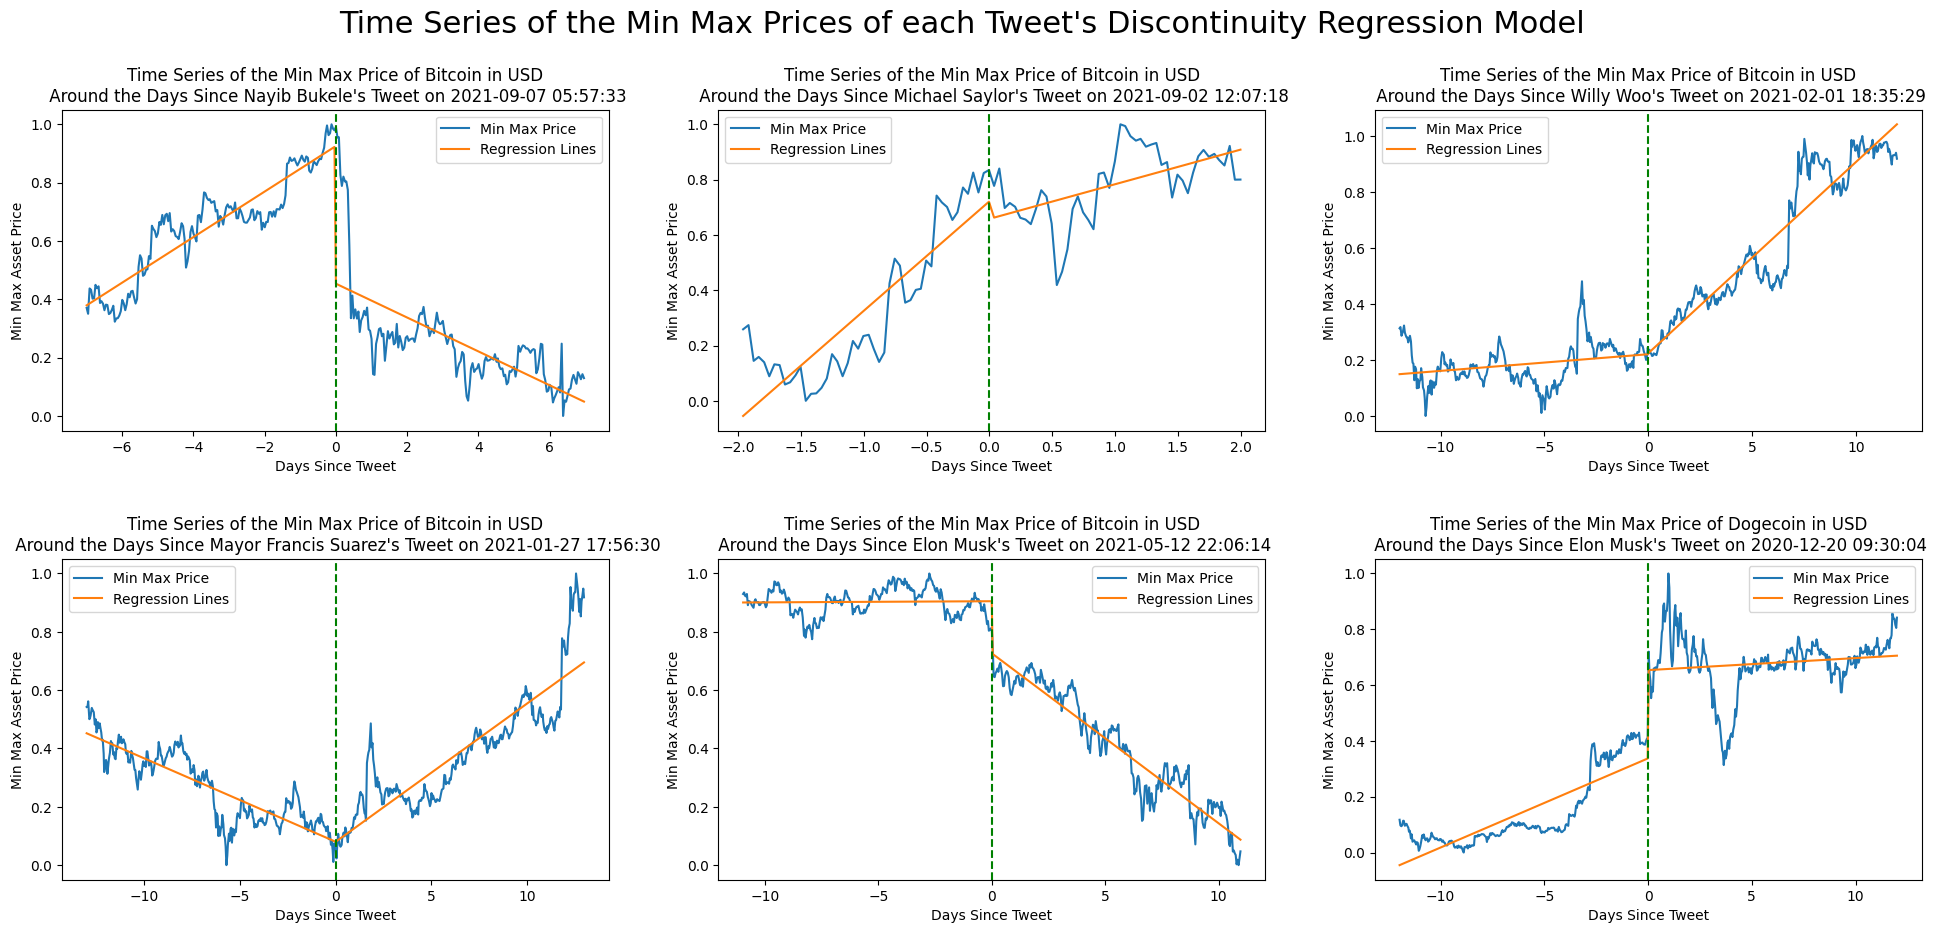

In [30]:
select_chosen_model(all_tweet_stats,window_sizes)
all_price_plots =all_price_over_time_plots(all_tweet_stats)

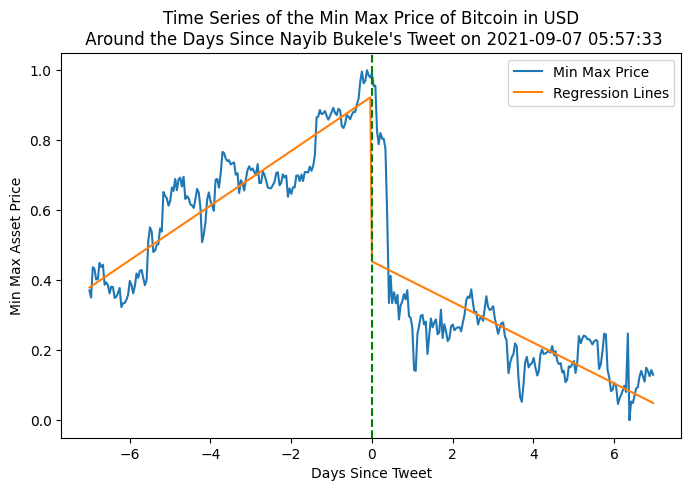

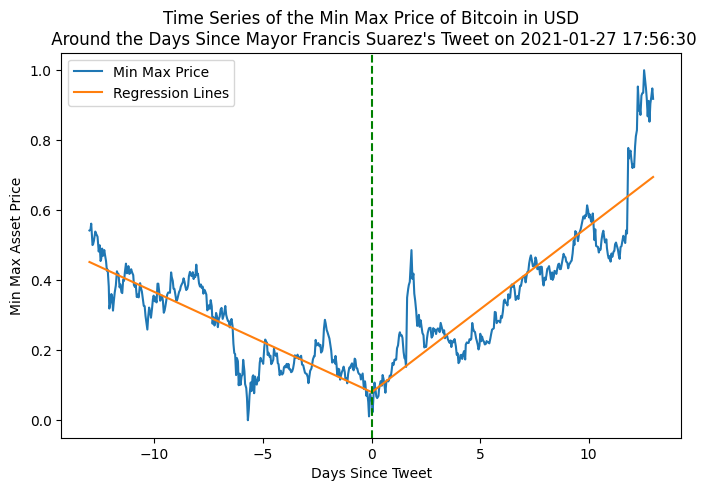

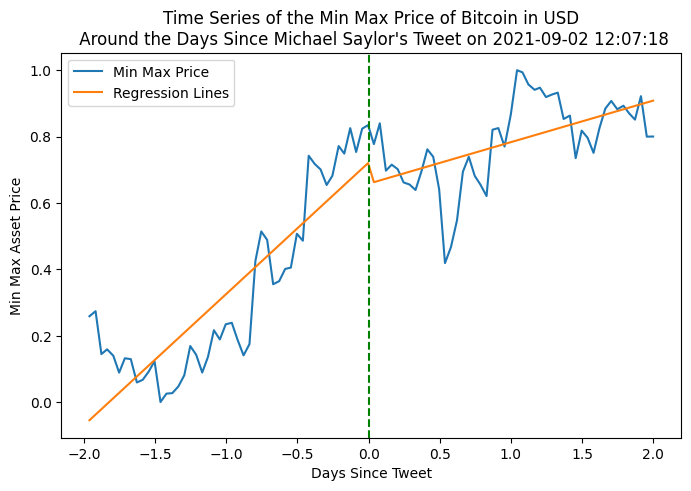

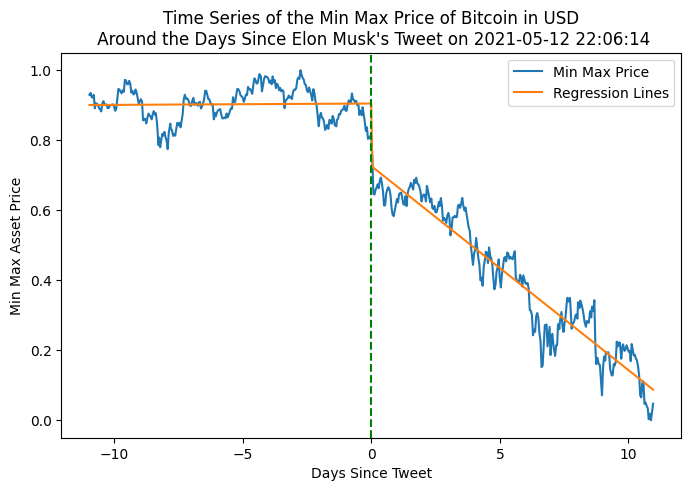

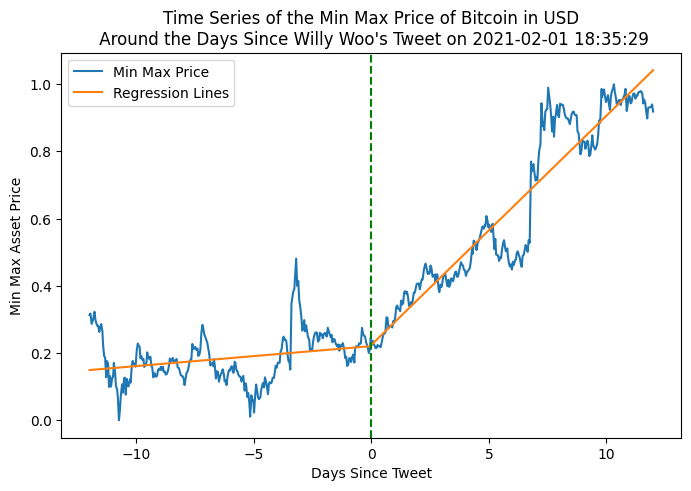

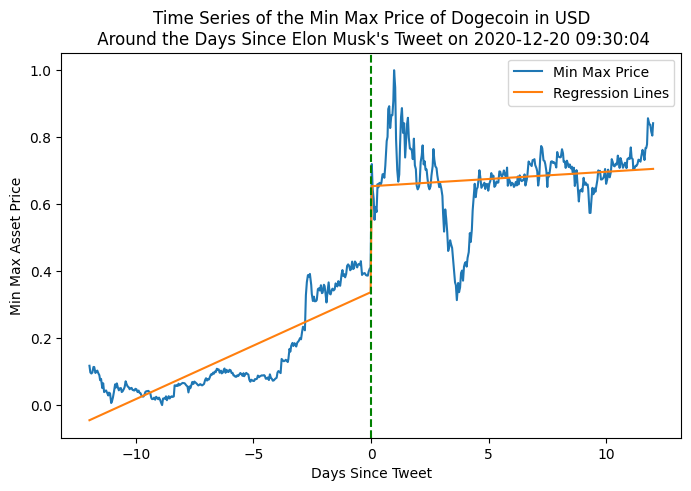

In [31]:
plots = produce_modeled_price_over_time_plots(all_tweet_stats)

In [32]:
def before_after_box_plot(tws,suptitle=False,ax=None):
    #ax = ax or plt.gca()
    df = tws.df
    twt_dt = tws.id
    coin = tws.coin
    currency = tws.currency
    creator = tws.creator
    window_size = tws.chosen_window_size
    sub_df = get_sub_df(df,twt_dt,window_size)
    sub_df.groupby(by='before_after').boxplot(column='prices',subplots=True,ax=ax)
    #remove individual titles
    ax[0].set_title('')
    ax[1].set_title('')
    #set common super title
    if suptitle:
        title = "Comparative Box Plot of {coin} Prices in {currency} \n Before and After {creator}'s Tweet at {twt_dt}".format(coin=coin.title(),currency=currency.upper(),creator=creator.title(),twt_dt=str(twt_dt))
        plt.suptitle(title)
    #separate x labels
    ax[0].set_xticklabels(['{coin} Prices Before Tweet'.format(coin=coin.title())])
    ax[1].set_xticklabels(['{coin} Prices After Tweet'.format(coin=coin.title())])
    #common y label
    ax[0].set_ylabel("{coin} Prices in {currency}".format(coin=coin.title(),currency=currency.upper()))
    return ax
def produce_before_after_box_plots(tws,single=False):
    box_plots = []
    for tweet_stats in tws:
        if single:
            fig,ax = plt.subplots(1,1,figsize=(5,5))
            box_plot = single_plot_box_plot(tweet_stats,ax=ax)
        else:
            fig,ax = plt.subplots(1,2,figsize=(8,5),sharey=True,sharex=False)
            box_plot = before_after_box_plot(tweet_stats,
                                             suptitle=True,
                                             ax=ax)
        box_plots.append(fig)
        #tweet_stats.chosen_model_box_plot = box_plot
    return box_plots
def single_plot_box_plot(tws,ax=None):
    ax = ax or plt.gca()
    df = tws.df
    twt_dt = tws.id
    coin = tws.coin
    currency = tws.currency
    creator = tws.creator
    window_size = tws.chosen_window_size
    sub_df = get_sub_df(df,twt_dt,window_size)
    before_df = sub_df[sub_df['before_after']==0]
    after_df = sub_df[sub_df['before_after']==1]
    data_to_plot = [before_df['prices'],after_df['prices']]
    box = ax.boxplot(data_to_plot,
                     positions=[1,2.5],
                     labels=['{coin} Prices {window} Days Before Tweet'.format(coin=coin.title(),window=str(window_size)),
                             '{coin} Prices {window} Days After Tweet'.format(coin=coin.title(),window=str(window_size))],
                    vert=True)
    ax.set_ylabel("{coin} Prices in {currency}".format(coin=coin.title(),currency=currency.upper()))
    title = "Comparative Box Plot of {coin} Prices in {currency} \n Before and After {creator}'s Tweet at {twt_dt}".format(coin=coin.title(),currency=currency.upper(),creator=creator.title(),twt_dt=str(twt_dt))
    ax.set_title(title)
def all_box_plots(tws):
    fig, ax = plt.subplots(2,3,figsize=(24,16))
    j=0
    tweets = 0
    for i in range(3):
        for j in range(2):
            single_plot_box_plot(tws[tweets],ax=ax[j][i])
            tweets+=1
    plt.subplots_adjust(hspace=0.2)
    plt.suptitle("Before and After Box Plots of the Asset Prices of each Tweet",
                fontsize=22)
    return fig

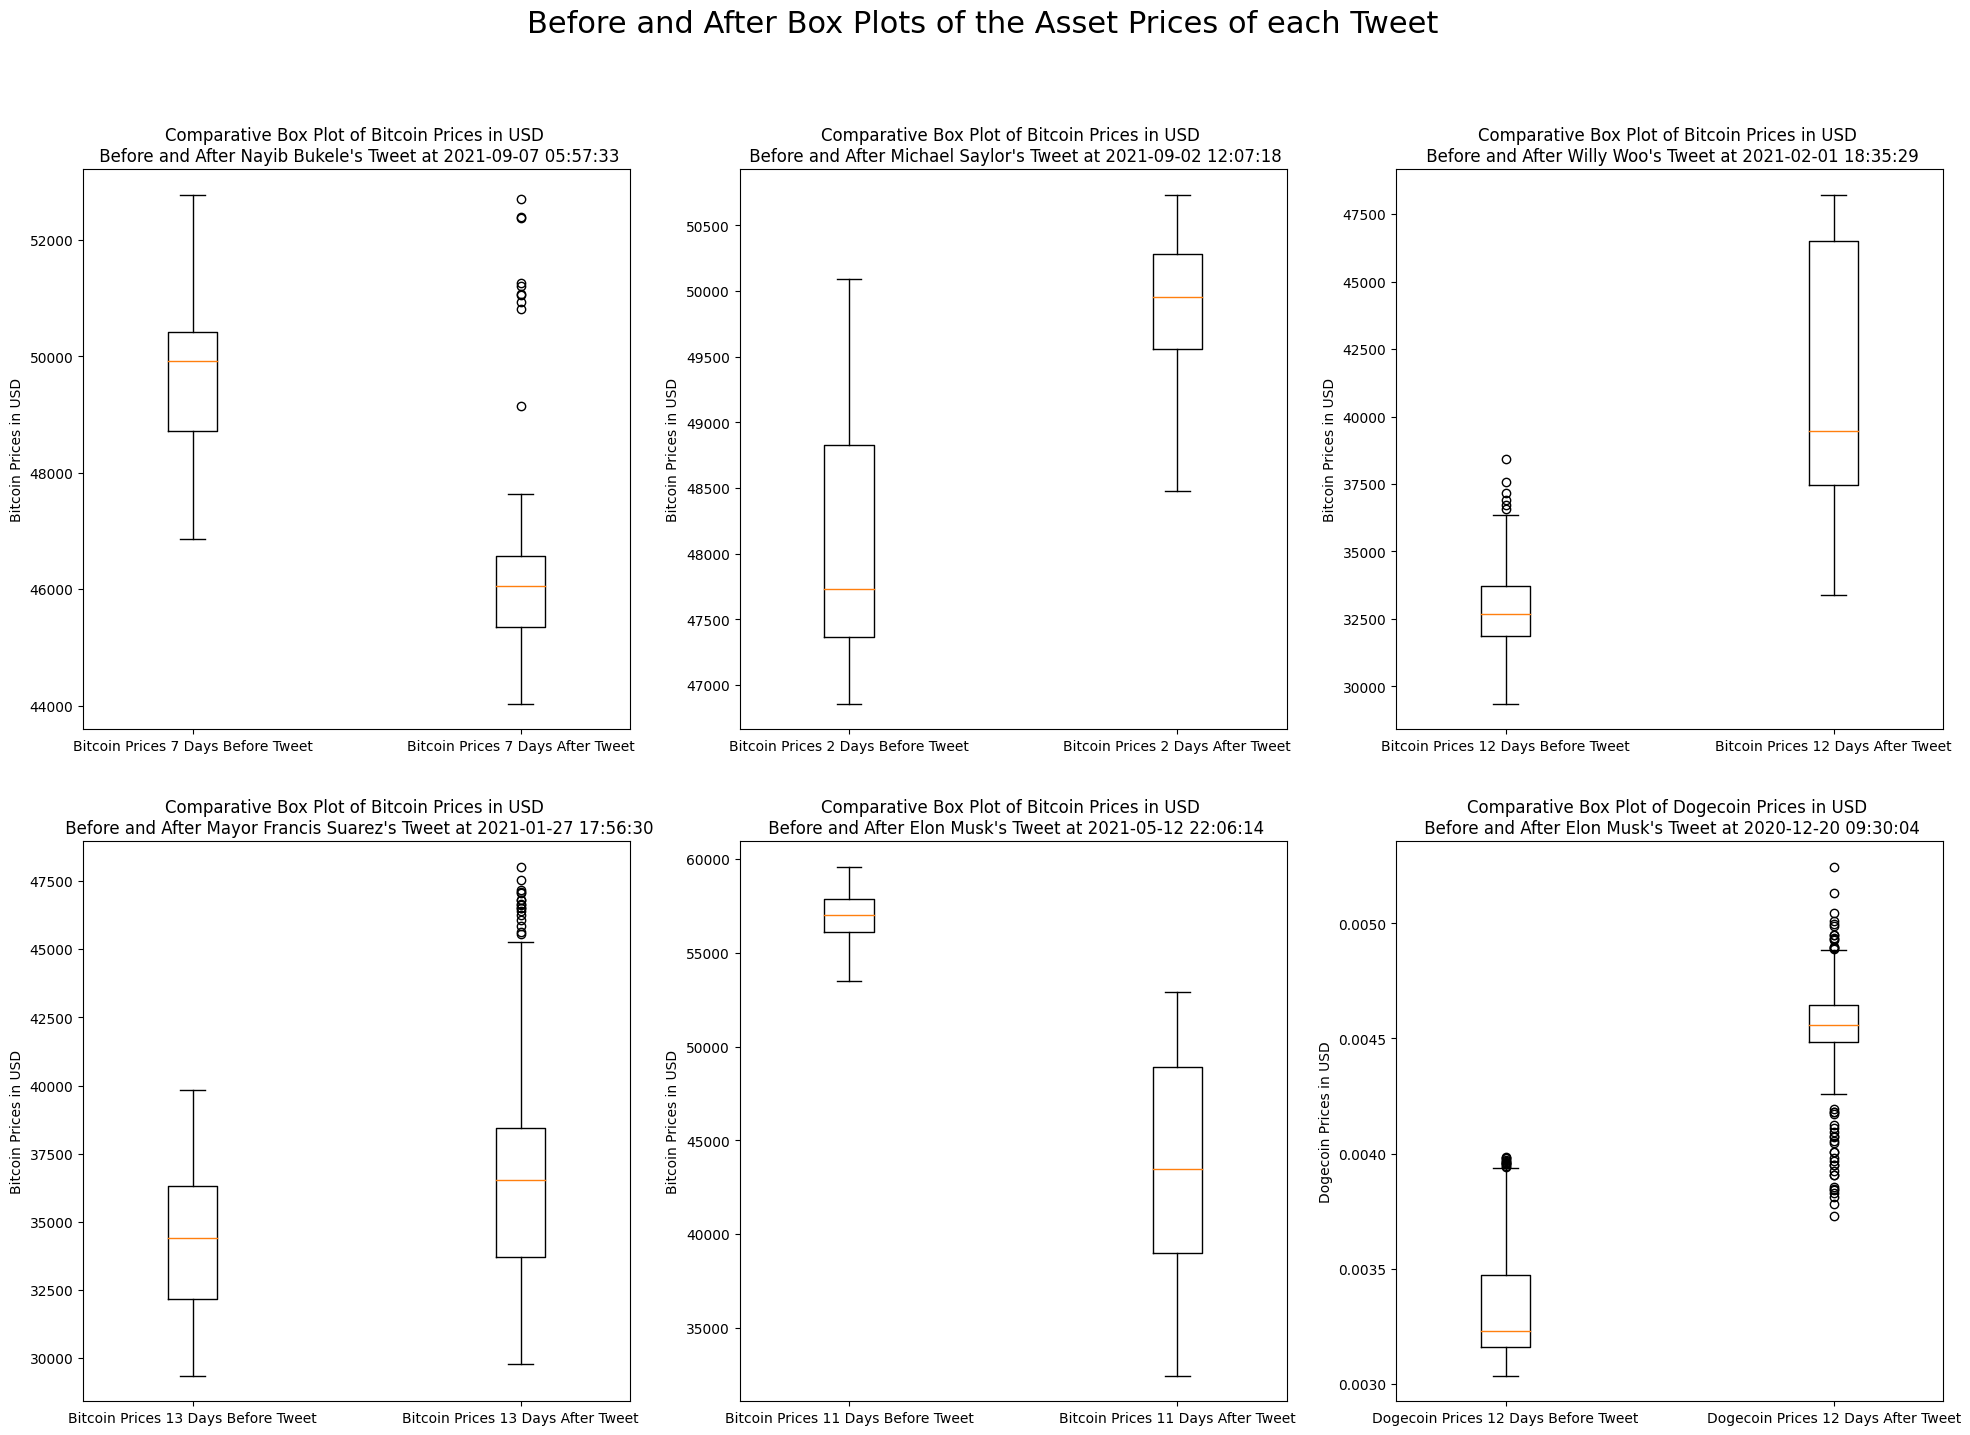

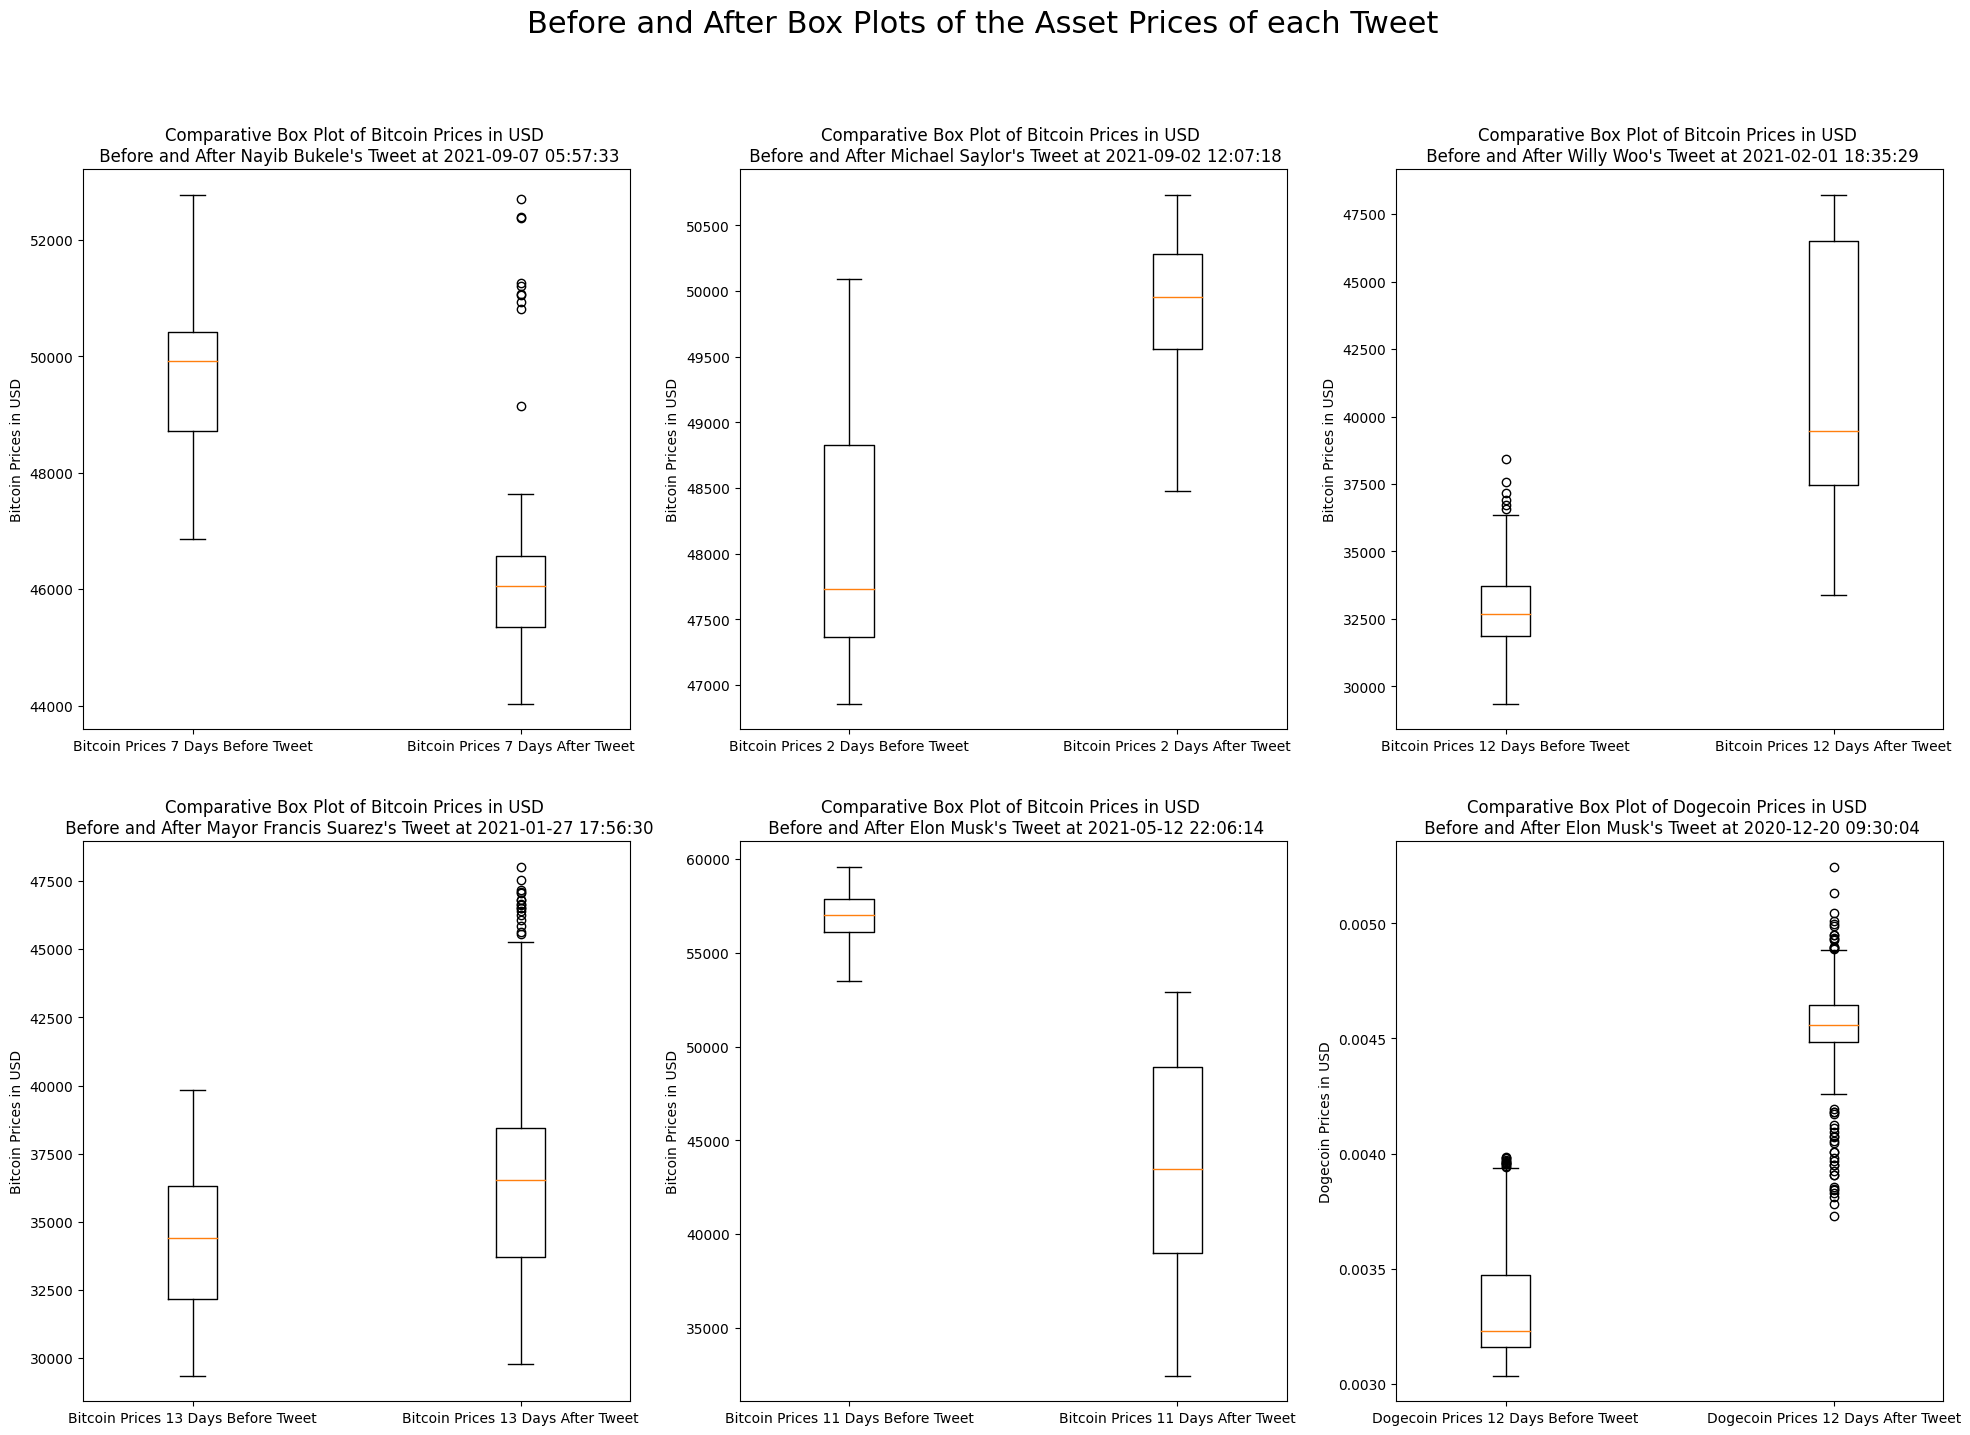

In [33]:
#produce_before_after_box_plots(all_tweet_stats,single=True)
all_box_plots(all_tweet_stats)

In [34]:
def perform_placebos(original_df,window_size=7,n=100,with_kernel=False,with_gaussian=False,asymmetry=False,d_bf=7,d_aft=2):
    models = []
    for i in tqdm (range(n),desc="Performing placebos..."):
        rand_twt_dt = random_tweet_dt(original_df,window_size,asymmetry,d_bf,d_aft)
        if asymmetry:
            rand_window_df = asymmetric_sub_df(original_df,rand_twt_dt,d_bf,d_aft)
        else:
            #rand_window_df = get_sub_df(original_df,rand_twt_dt,90)
            #prices_cycle, prices_trend = hpfilter(rand_window_df['min_max_prices'],lamb=1600)
            #rand_window_df['hp_filtered'] = prices_trend
            rand_window_df = get_sub_df(original_df,rand_twt_dt,window_size)
        if with_kernel:
            model = wls('min_max_prices ~ days_since_tweet * before_after',
                        rand_window_df,
                        weights=kernel(rand_window_df['days_since_tweet'],c=0,h=window_size)).fit()
        if with_gaussian:
            model = wls('min_max_prices ~ days_since_tweet * before_after',
                        rand_window_df,
                        weights=gaussian_kernel(rand_window_df['days_since_tweet'],c=0,h=(d_bf/2))).fit()
            
        else:
            model = ols('min_max_prices ~ days_since_tweet * before_after',rand_window_df).fit()   
        models.append(model)
    return models
def produce_placebo_models(tws,n=1000):
    placebos = []
    for tweet_stats in tws:
        df = tweet_stats.df
        twt_dt = tweet_stats.id
        window_size = tweet_stats.chosen_window_size
        placebo_models = perform_placebos(df,window_size,n)
        tweet_stats.placebo_models = placebo_models
        placebos.append(placebo_models)
    return placebos
        

In [35]:
produce_placebo_models(all_tweet_stats)

Performing placebos...: 100%|██████████| 1000/1000 [01:36<00:00, 10.36it/s]


[[<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7f94fc38d130>,

In [36]:
def produce_coeff_hist(tws,ax=None,bins=15):
    ax= ax or plt.gca()
    
    placebos = tws.placebo_models
    chosen_model = tws.chosen_model
    coefficient = chosen_model.params['before_after']
    window_size = tws.chosen_window_size
    coin = tws.coin
    currency = tws.currency
    creator = tws.creator
    twt_dt = tws.id
    placebo_coeffs = pd.DataFrame(pd.Series(placebos).map(lambda x: x.params['before_after']))
    
    placebo_coeffs.plot.hist(alpha=0.5,bins=bins,edgecolor='white',density=True,ax=ax)
    

    #because we turned placebo_coeffs into a dataframe
    mu, se = norm.fit(placebo_coeffs[0])
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin,xmax,100)
    p = norm.pdf(x,mu,se)
    ax.plot(x,p,'k',linewidth=2)

    ax.axvline(coefficient,color='green')
    ax.axvline(mu,color='red')
    #plt.axvline(1.645*se,color='orange',linestyle='--')
    ax.axvline(1.96*se,color='orange',linestyle='--')
    #plt.axvline(-1.645*se,color='orange',linestyle='--')
    ax.axvline(-1.96*se,color='orange',linestyle='--')
    
    ax.set_title("Histogram of the Coefficients of {n} Placebo Discontinuity \n Regression Models with Window Size {window_size} on Price Data of {coin} vs {currency} \n around {creator}'s Tweet on {timestamp}'".format(coin=coin.title(),
                                                                                                                                                                               n=str(len(placebo_coeffs)),
                                                                                                                                                                               currency=currency.upper(),
                                                                                                                                                                               window_size=window_size,
                                                                                                                                                                               creator=creator.title(),
                                                                                                                                                                               timestamp=str(twt_dt)))
    
    ax.set_xlabel('Coefficients of Placebo Regression Models')
    ax.set_ylabel('Density')

    ax.legend(['Placebo Coefficients',"Normal Approximation","Chosen Model Coefficient",'Mean','95th Percentiles'],loc='upper left',fontsize=9)
    return ax
    
    
    return ax
def produce_placebo_histograms(tws,bins=15):
    placebo_hists = []
    for tweet_stats in tws:
        fig, ax = plt.subplots(1,1,figsize=(8,5))
        histogram = produce_coeff_hist(tweet_stats,ax=ax,bins=bins)
        #tweet_stats.placebo_hist = histogram
        placebo_hists.append(fig)
    return placebo_hists
def all_placebo_hists(tws):
    fig, ax = plt.subplots(2,3,figsize=(24,14))
    j=0
    tweets=0
    for i in range(3):
        for j in range(2):
            produce_coeff_hist(tws[tweets],ax=ax[j][i])
            tweets+=1
    plt.subplots_adjust(hspace=0.4)
    plt.suptitle("Histogram of the Coefficients of each Tweet's Placebo Discontinuity Regressions",
                fontsize=22)
    return fig

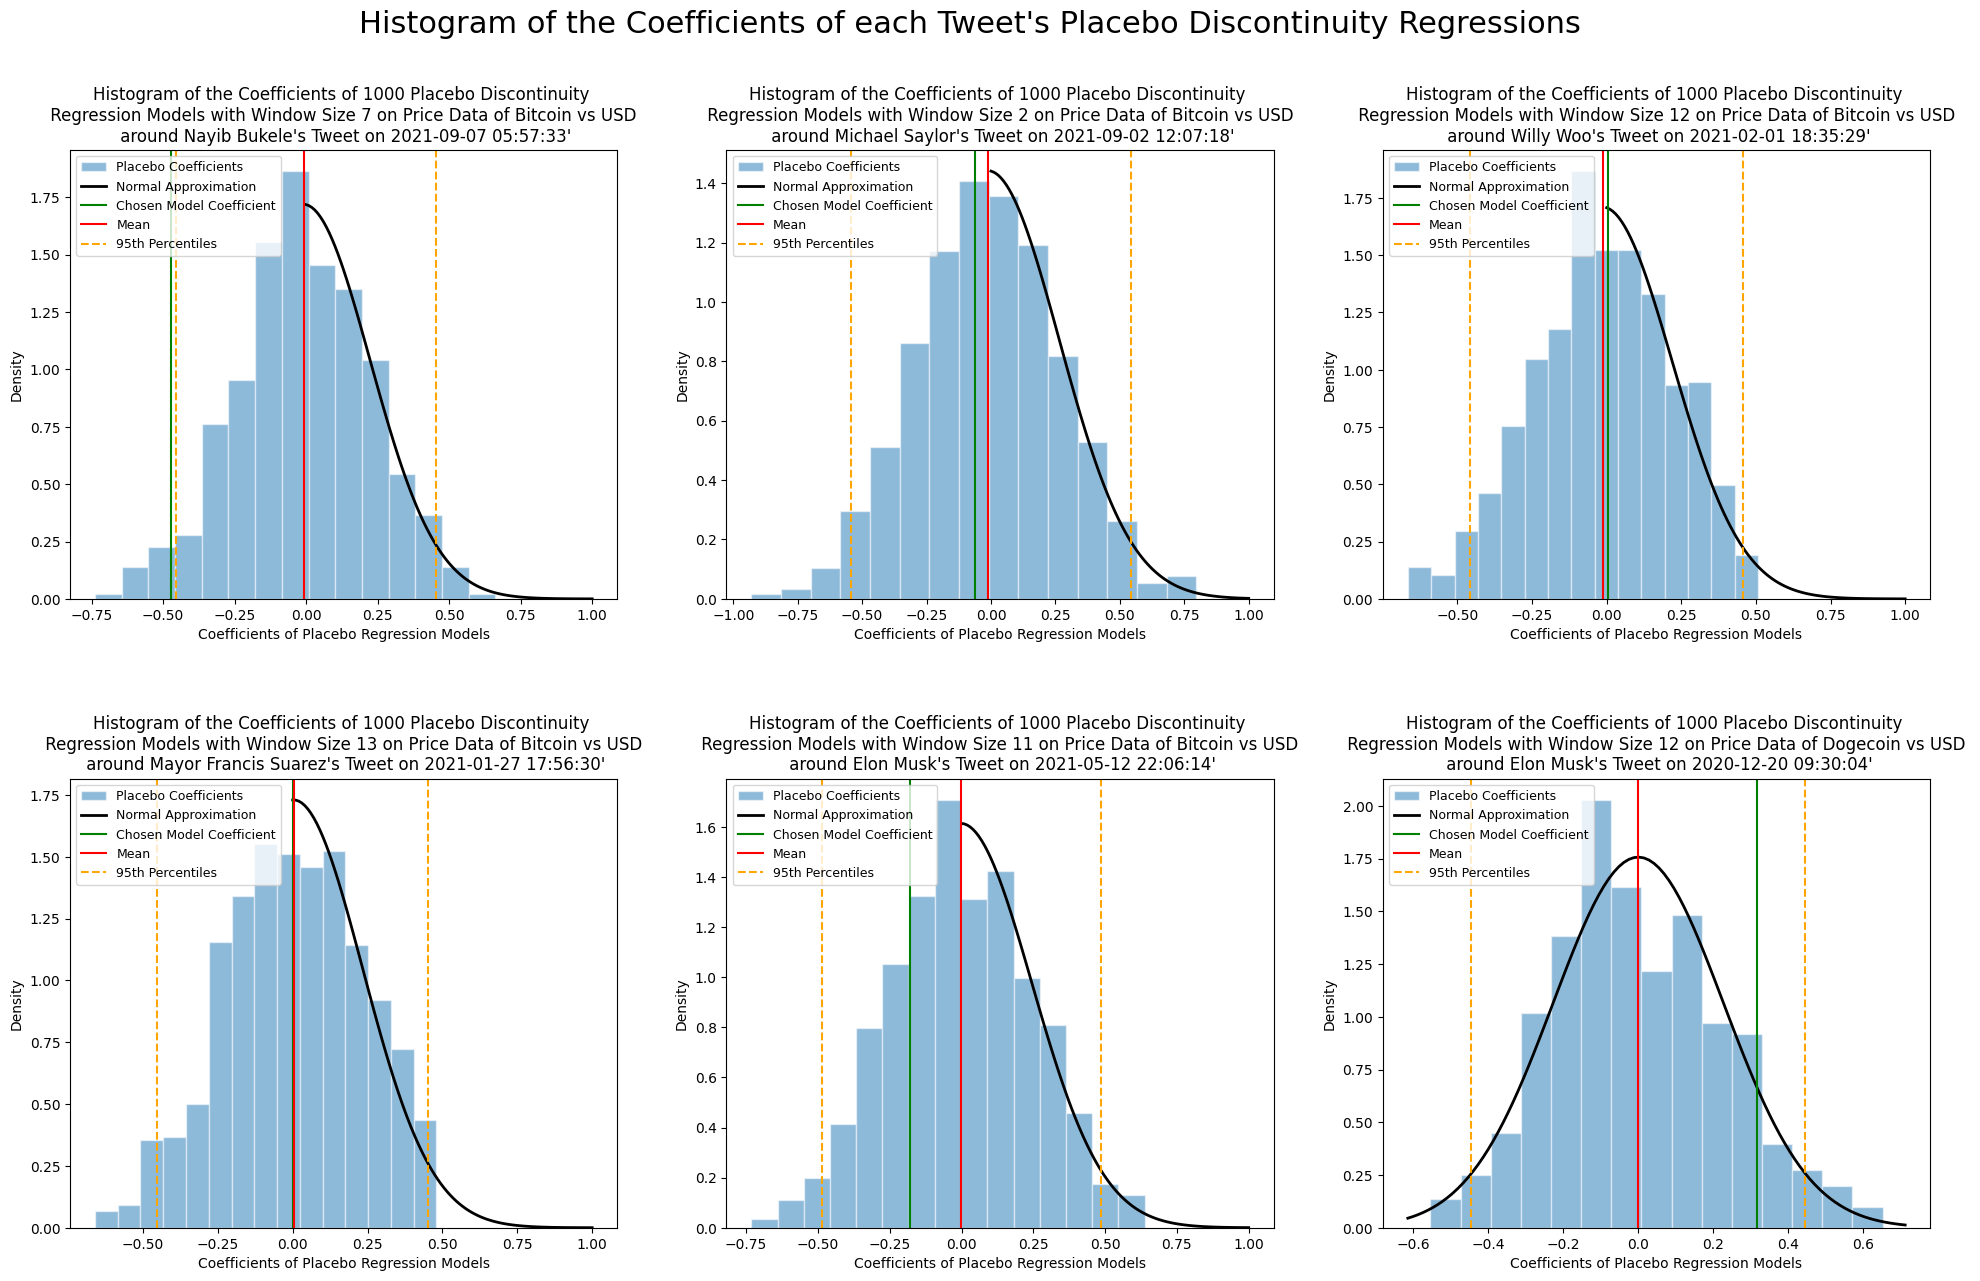

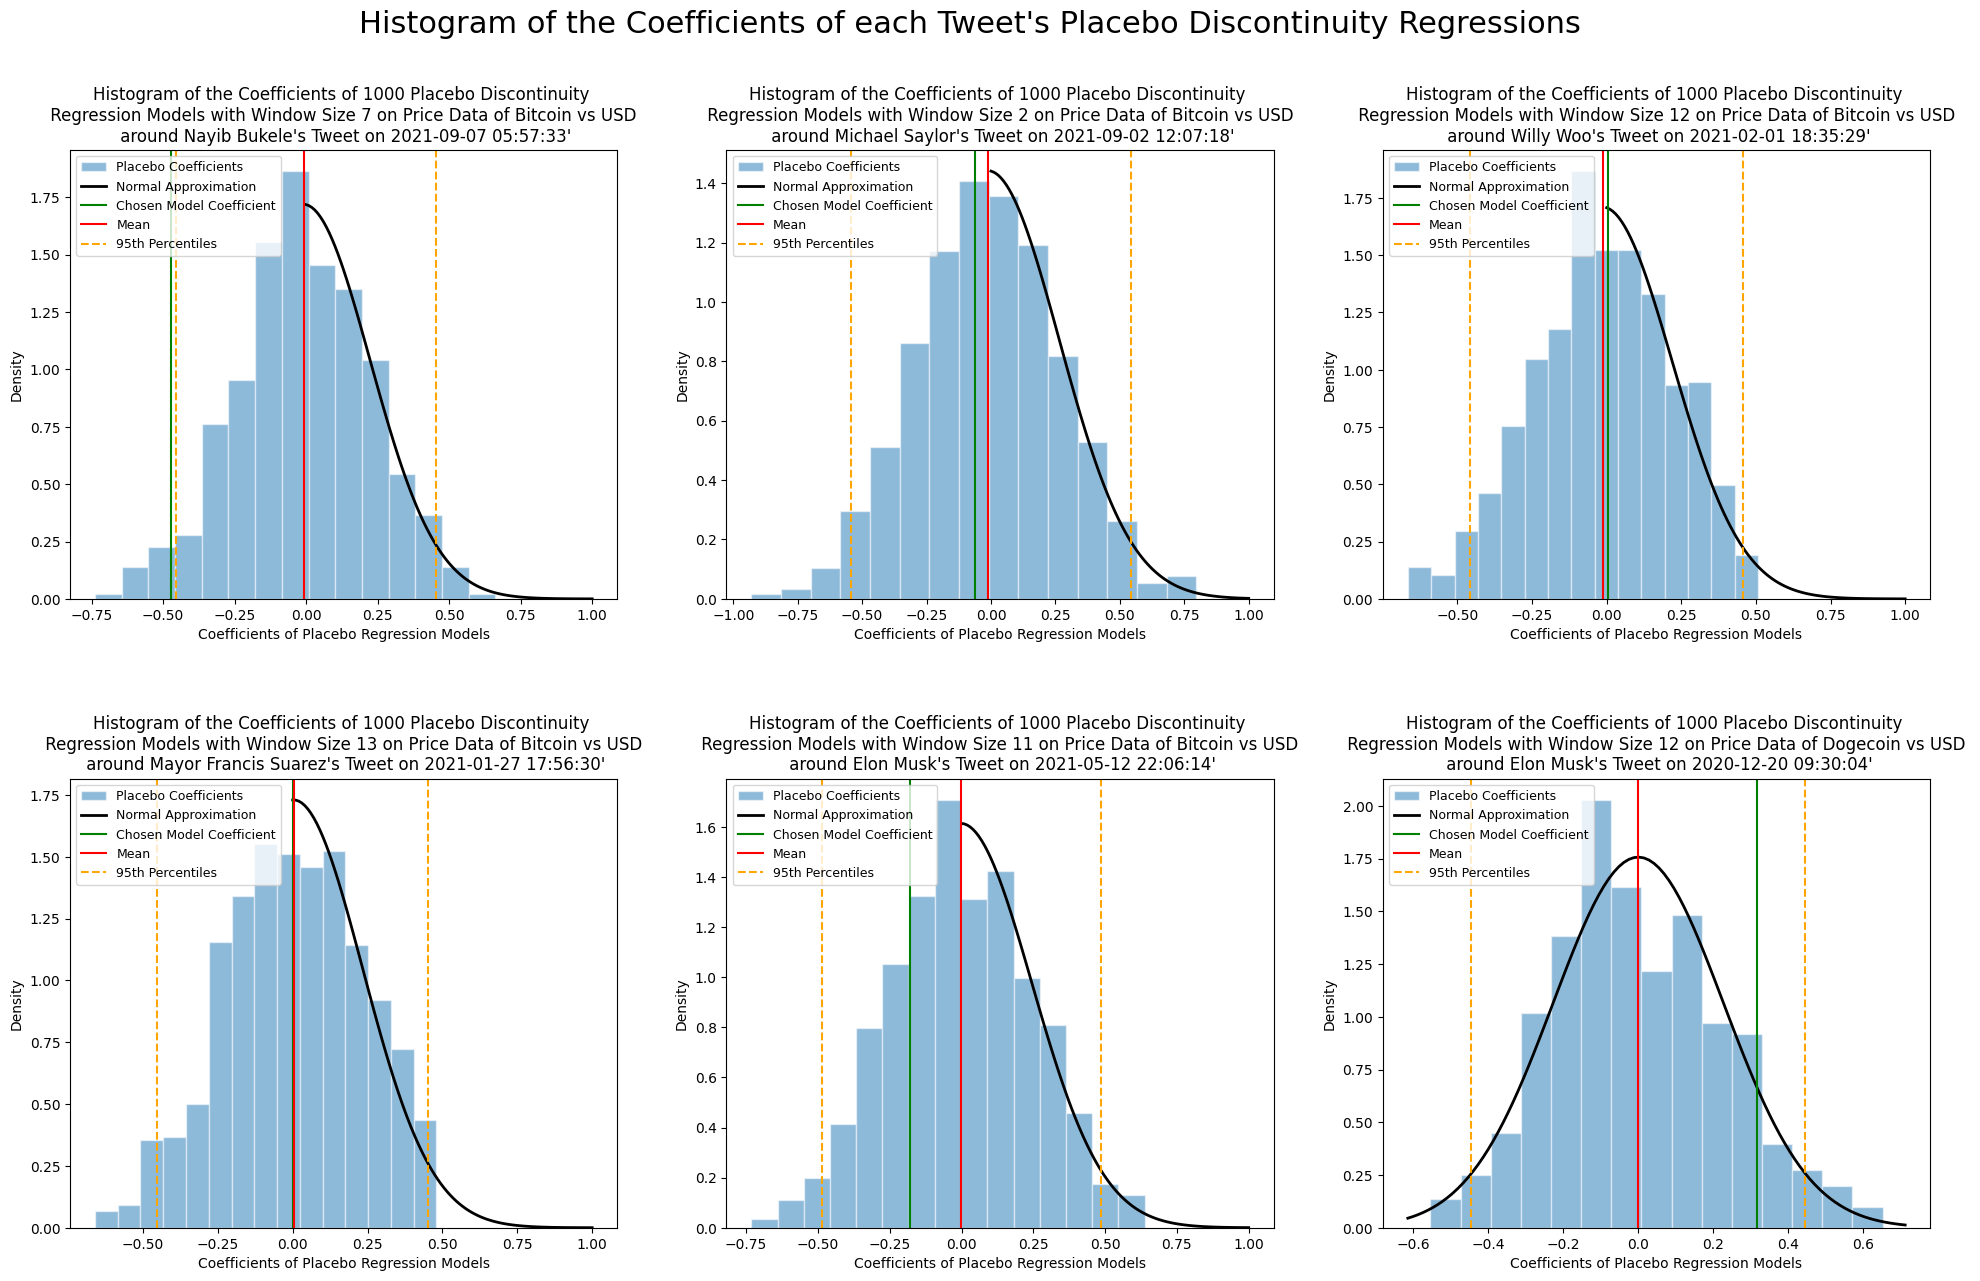

In [37]:
#figs=produce_placebo_histograms(all_tweet_stats)
all_placebo_hists(all_tweet_stats)

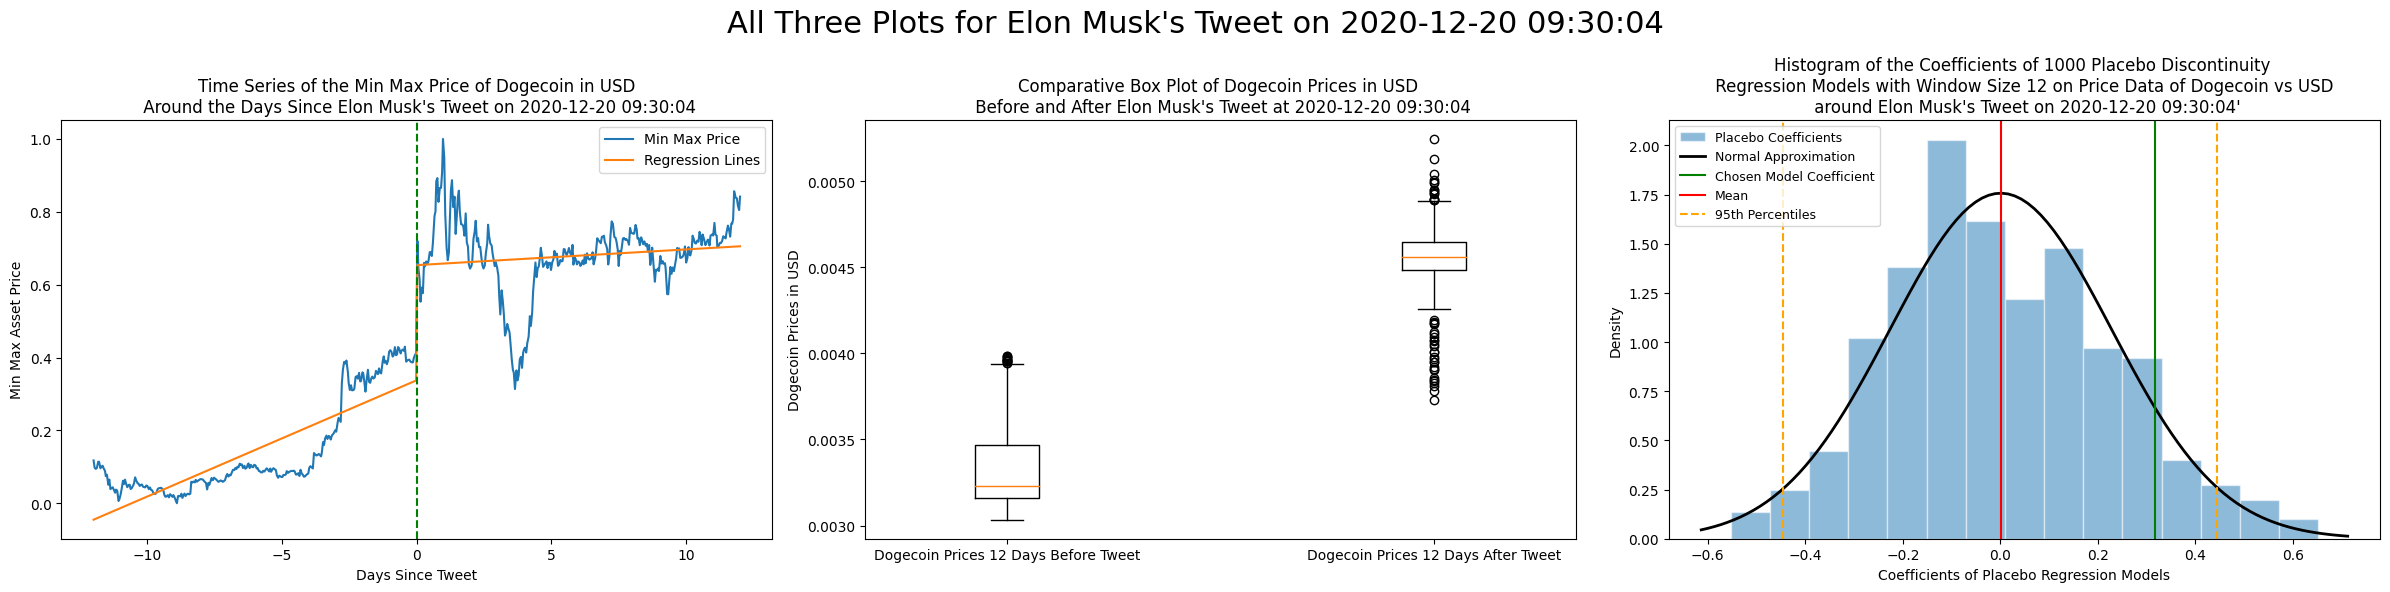

In [38]:
def all_three_plots(tws):
    fig,ax = plt.subplots(1,3,figsize=(24,6))
    price_over_time_plot(tws,ax=ax[0])
    single_plot_box_plot(tws,ax=ax[1])
    produce_coeff_hist(tws,ax=ax[2])
    creator = tws.creator
    twt_dt = tws.id
    plt.suptitle("All Three Plots for {creator}'s Tweet on {timestamp}".format(creator=creator.title(),timestamp=str(twt_dt)),fontsize=22)
    fig.tight_layout()
all_three_plots(all_tweet_stats[5])

In [39]:
def all_prices_in_one_plot(tws):
    for tweet_stats in tws:
        df = tweet_stats.df
        twt_dt = tweet_stats.id
        window_size = tweet_stats.chosen_window_size
        sub_df = get_sub_df(df,twt_dt,window_size)
        creator = tweet_stats.creator
        plt.plot(sub_df['days_since_tweet'],
                 sub_df['min_max_prices'],
                 label="{creator} {timestamp}".format(creator=creator.title(),timestamp=str(twt_dt)))
        plt.xlabel("Days Since Tweet")
        plt.ylabel("Min Max Prices of Assets")
    plt.axvline(0,linestyle='--',color='black')
    #plt.legend(fontsize=8)
    return plt
f = all_tweet_stats[0].chosen_model_plot

AttributeError: 'TweetStats' object has no attribute 'chosen_model_plot'

In [ ]:
all_prices_in_one_plot(all_tweet_stats[:6])

In [ ]:
df = all_tweet_stats[0].df
tweet_datetime = all_tweet_stats[0].id
one_day = get_sub_df(df,tweet_datetime,0.75)
one_day_model = ols('min_max_prices ~ days_since_tweet * before_after',one_day).fit()
ax = one_day.plot(y='min_max_prices',x='days_since_tweet',kind="line")
one_day.assign(predictions=one_day_model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
plt.axvline(0,color='green',linestyle='--')

In [ ]:
one_day_w_model = wls('min_max_prices ~ days_since_tweet * before_after',one_day,weights=gaussian_kernel(one_day['days_since_tweet'],c=0,h=0.5)).fit()
ax_w1 = one_day.plot(y='min_max_prices',x='days_since_tweet')
one_day.assign(predictions=one_day_w_model.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax_w1,color='C1')
plt.axvline(0,color='green',linestyle='--')

In [ ]:
seven_days = get_sub_df(df,tweet_datetime,90)
prices_cycle, prices_trend = hpfilter(seven_days['min_max_prices'],lamb=1600)

In [ ]:
#prices_trend.plot()
seven_days.plot(y='min_max_prices',x='date')
#prices_cycle.plot()

In [ ]:
prices_trend.plot()

In [ ]:
one_day['hp_min_max'] = hpfilter(one_day['min_max_prices'],lamb=10)[1]

In [ ]:
one_day_hp_m = ols('hp_min_max ~ days_since_tweet * before_after',one_day).fit()
ax = one_day.plot(y='hp_min_max',x='days_since_tweet')
one_day.assign(predictions=one_day_hp_m.fittedvalues).plot(x='days_since_tweet',y='predictions',ax=ax,color='C1')
plt.axvline(0,color='green',linestyle='--')